In [64]:
import numpy as np 
import matplotlib.pyplot as plt 
import hickle
from ase.units import Hartree

In [53]:
def get_mean_error(predictions, target):
    first = (predictions[::2] + predictions[1::2]).flatten() / 2.0
    second = (target[::2] + target[1::2]).flatten() / 2.0
    values = first - second
    error = np.sqrt(np.mean(values ** 2))
    return error 

def get_delta_error(predictions, target):
    first = (predictions[::2]-predictions[1::2]).flatten()
    second = (target[::2]-target[1::2]).flatten()
    values = first - second
    error = np.sqrt(np.mean( values ** 2 ))   
    return error

def get_all_errors(predictions_train, predictions_val, target_train, target_val, relative=True):
#     target_full = np.concatenate([target_train, target_val], axis = 0)
    print("target_train.shape", target_train.shape)
    print("target_val.shape", target_val.shape)
    mean_error_train = get_mean_error(predictions_train, target_train)
    mean_error_val = get_mean_error(predictions_val, target_val)
    delta_error_train = get_delta_error(predictions_train, target_train)
    delta_error_val = get_delta_error(predictions_val, target_val)
#     normalization_mean = np.std(target_full)
    normalization_mean_train = np.std(target_train)
    normalization_mean_val = np.std(target_val)
    norm_delta_train = np.std(target_train[::2] - target_train[1::2])
    norm_delta_val = np.std(target_val[::2] - target_val[1::2])
#     normalization_delta = np.std(target_full[::2]-target_full[1::2])
    if relative:
        print("normalized")
        mean_error_train = mean_error_train / normalization_mean_train#normalization_mean
        mean_error_val = mean_error_val / normalization_mean_val#normalization_mean
        delta_error_train = delta_error_train / norm_delta_train#normalization_delta
        delta_error_val = delta_error_val / norm_delta_val#normalization_delta 
        
    return mean_error_train, mean_error_val, delta_error_train, delta_error_val



## Features

In [54]:
feats_nu_to7 = hickle.load('bisp/feat_1234567_PCA.hickle')
output_size = feats_nu_to7.shape[-1]
target = feats_nu_to7[:,:output_size]
ntrain = 7000

### linear 

In [55]:
pred_lin = np.load('bisp/pred_feat/silu_lin8k.npy')

In [56]:
lin_mean_train, lin_mean_val, lin_delta_train, lin_delta_val = get_all_errors(pred_lin[:7000], pred_lin[7000:], feats_nu_to7[:7000], feats_nu_to7[7000:])
print("mean train error: ",lin_mean_train )
print("mean test error: ",lin_mean_val )
print("delta train error: ",lin_delta_train )
print("delta val train error: ",lin_delta_val )


target_train.shape (7000, 8000)
target_val.shape (1000, 8000)
normalized
mean train error:  0.009852770000171917
mean test error:  0.017416600517321922
delta train error:  1.0000000010279626
delta val train error:  1.0000000031103427


0.011056593343501751 1.0000536525794215


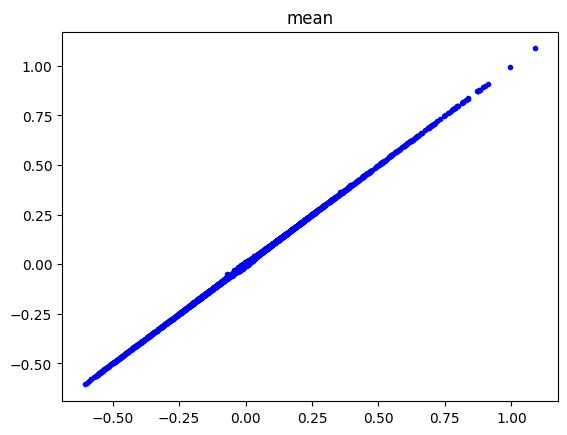

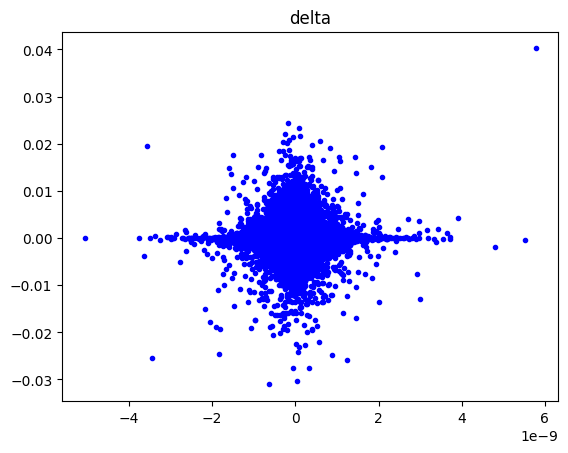

In [19]:
plt.plot((pred_lin[::2]+pred_lin[1::2])[ntrain//2:]/2, (target[::2]+target[1::2])[ntrain//2:]/2,'b.')
plt.title("mean")
plt.figure()
plt.plot((pred_lin[::2]-pred_lin[1::2])[ntrain//2:], (target[::2]-target[1::2])[ntrain//2:],'b.')
plt.title('delta')
print( 
    np.sqrt(np.mean( ((pred_lin[::2]+pred_lin[1::2]).flatten()[ntrain//2:]/2-(target[::2]+target[1::2]).flatten()[ntrain//2:]/2)**2 )) /np.std(target)
    ,
    np.sqrt(np.mean( ((pred_lin[::2]-pred_lin[1::2]).flatten()[ntrain//2:]-(target[::2]-target[1::2]).flatten()[ntrain//2:])**2 )) /np.std(target[::2]-target[1::2])     
     )

### non-linear

In [13]:
pred_nl = np.load('bisp/pred_feat/silu_nl8k.npy')

In [23]:
nl_mean_train, nl_mean_val, nl_delta_train, nl_delta_val = get_all_errors(pred_nl[:7000], pred_nl[7000:], feats_nu_to7[:7000], feats_nu_to7[7000:])

print("mean train error: ",nl_mean_train )
print("mean test error: ",nl_mean_val )
print("delta train error: ",nl_delta_train )
print("delta val train error: ",nl_delta_val )

target_train.shape (7000, 8000)
target_val.shape (1000, 8000)
mean train error:  0.004352581283773807
mean test error:  0.006698606461081356
delta train error:  0.125429454333545
delta val train error:  0.14332104851049665


0.004700671671458836 0.12762845331134298


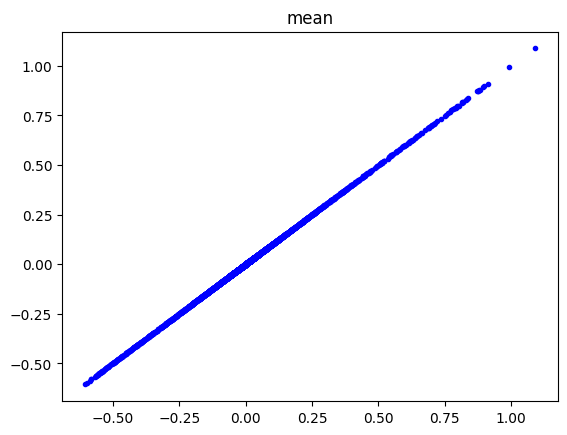

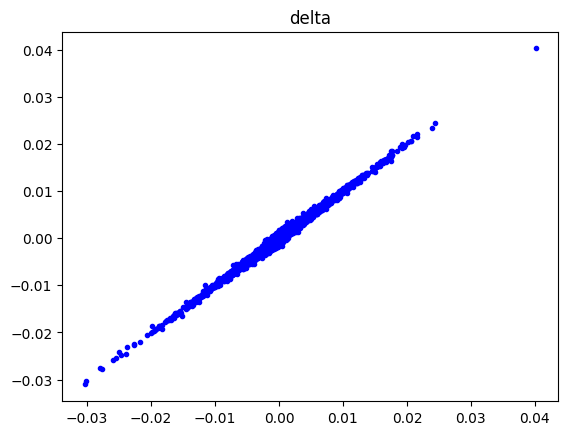

In [20]:
plt.plot((pred_nl[::2]+pred_nl[1::2])[ntrain//2:]/2, (target[::2]+target[1::2])[ntrain//2:]/2,'b.')
plt.title("mean")
plt.figure()
plt.plot((pred_nl[::2]-pred_nl[1::2])[ntrain//2:], (target[::2]-target[1::2])[ntrain//2:],'b.')
plt.title('delta')
print( 
    np.sqrt(np.mean( ((pred_nl[::2]+pred_nl[1::2]).flatten()[ntrain//2:]/2-(target[::2]+target[1::2]).flatten()[ntrain//2:]/2)**2 )) /np.std(target)
    ,
    np.sqrt(np.mean( ((pred_nl[::2]-pred_nl[1::2]).flatten()[ntrain//2:]-(target[::2]-target[1::2]).flatten()[ntrain//2:])**2 )) /np.std(target[::2]-target[1::2])     
     )

## Intermediate Energies

In [63]:
e0 = -198.27291671238572
from ase.io import read
import ast 
frames = read('bisp/boron_8000_pbeccpvdz.xyz', ':8000')
for fi, f in enumerate(frames):
    f.info["energy_rel"] = (f.info["energy_ha"]-e0)#*Hartree
    for n, v in zip( ("index", "label","r", "z_1", "z_2", "psi", "phi_1", "phi_2"), ast.literal_eval(f.info["pars"]) ):
        f.info[n] = v 
    if fi%2 ==1:
        frames[fi].info["delta"] = np.abs(frames[fi].info["energy_rel"]-frames[fi-1].info["energy_rel"])
        frames[fi-1].info["delta"] = frames[fi].info["delta"]
energy = np.asarray([f.info["energy_rel"] for f in frames])

### from lin, lin decoder

In [51]:
pred_fromlinlin = np.load('bisp/pred_feat/energy/linlin_encoded_energy.npy')

In [52]:
fromlinlin_mean_train, fromlinlin_mean_val, fromlinlin_delta_train, fromlinlin_delta_val = get_all_errors(pred_fromlinlin[:7000], pred_fromlinlin[7000:], energy[:7000], energy[7000:])
print("mean train error: ",fromlinlin_mean_train )
print("mean test error: ",fromlinlin_mean_val )
print("delta train error: ",fromlinlin_delta_train )
print("delta val train error: ",fromlinlin_delta_val )

target_train.shape (7000,)
target_val.shape (1000,)
mean train error:  0.4102880759959699
mean test error:  0.39092258408261604
delta train error:  1.0000023733357435
delta val train error:  1.0001233914499326


In [67]:
fromlinlin_mean_train, fromlinlin_mean_val, fromlinlin_delta_train, fromlinlin_delta_val = get_all_errors(pred_fromlinlin[:7000], pred_fromlinlin[7000:], energy[:7000], energy[7000:],relative=False)
print("ABSOLUTE in eV")
print("mean train error: ",fromlinlin_mean_train*Hartree)
print("mean test error: ",fromlinlin_mean_val*Hartree )
print("delta train error: ",fromlinlin_delta_train*Hartree )
print("delta val train error: ",fromlinlin_delta_val*Hartree )

target_train.shape (7000,)
target_val.shape (1000,)
ABSOLUTE in eV
mean train error:  1.5759592795062207
mean test error:  1.667459562567401
delta train error:  0.2501269133409327
delta val train error:  0.24509101376412618


### lin encoder, non linear decoder

In [33]:
pred_fromlin = np.load('bisp/pred_feat/energy/lin_encoded_energy.npy')

In [34]:
fromlin_mean_train, fromlin_mean_val, fromlin_delta_train, fromlin_delta_val = get_all_errors(pred_fromlin[:7000], pred_fromlin[7000:], energy[:7000], energy[7000:])
print("mean train error: ",fromlin_mean_train )
print("mean test error: ",fromlin_mean_val )
print("delta train error: ",fromlin_delta_train )
print("delta val train error: ",fromlin_delta_val )


target_train.shape (7000,)
target_val.shape (1000,)
mean train error:  0.028345945048963726
mean test error:  0.1726140448410326
delta train error:  1.0000023680757848
delta val train error:  1.0001234075849286


In [69]:
fromlin_mean_train, fromlin_mean_val, fromlin_delta_train, fromlin_delta_val = get_all_errors(pred_fromlin[:7000], pred_fromlin[7000:], energy[:7000], energy[7000:],relative=False)

print("ABSOLUTE in eV")
print("mean train error: ",fromlin_mean_train*Hartree)
print("mean test error: ",fromlin_mean_val*Hartree )
print("delta train error: ",fromlin_delta_train*Hartree )
print("delta val train error: ",fromlin_delta_val*Hartree )

target_train.shape (7000,)
target_val.shape (1000,)
ABSOLUTE in eV
mean train error:  0.10887973048655353
mean test error:  0.7362760593099674
delta train error:  0.2501269120252786
delta val train error:  0.24509101771818081


### from nl 

In [35]:
pred_fromnl = np.load('bisp/pred_feat/energy/nl_encoded_energy.npy')

In [36]:
fromnl_mean_train, fromnl_mean_val, fromnl_delta_train, fromnl_delta_val = get_all_errors(pred_fromnl[:7000], pred_fromnl[7000:], energy[:7000], energy[7000:])
print("mean train error: ",fromnl_mean_train )
print("mean test error: ",fromnl_mean_val )
print("delta train error: ",fromnl_delta_train )
print("delta val train error: ",fromnl_delta_val )

target_train.shape (7000,)
target_val.shape (1000,)
mean train error:  0.0015317472814490897
mean test error:  0.11033838259912912
delta train error:  0.048115292051536425
delta val train error:  0.45723273101822215


In [70]:
fromnl_mean_train, fromnl_mean_val, fromnl_delta_train, fromnl_delta_val = get_all_errors(pred_fromnl[:7000], pred_fromnl[7000:], energy[:7000], energy[7000:], relative=False)
print("ABSOLUTE in eV")
print("mean train error: ",fromnl_mean_train *Hartree)
print("mean test error: ",fromnl_mean_val*Hartree )
print("delta train error: ",fromnl_delta_train*Hartree )
print("delta val train error: ",fromnl_delta_val*Hartree )

target_train.shape (7000,)
target_val.shape (1000,)
ABSOLUTE in eV
mean train error:  0.005883601019108903
mean test error:  0.4706425227769797
delta train error:  0.012034900922487789
delta val train error:  0.11204980758317373


## Energies 

### lin

In [72]:
pred_lin = np.load('bisp/pred_energy/batchmc2_lin_triple_energy_LBFGS.npy')

In [39]:
lin_mean_train, lin_mean_val, lin_delta_train, lin_delta_val = get_all_errors(pred_lin[:7000], pred_lin[7000:], energy[:7000], energy[7000:])
print("mean train error: ",lin_mean_train )
print("mean test error: ",lin_mean_val )
print("delta train error: ",lin_delta_train )
print("delta val train error: ",lin_delta_val )


target_train.shape (7000,)
target_val.shape (1000,)
mean train error:  0.41694461033341307
mean test error:  0.38510917844709885
delta train error:  1.0000023738252333
delta val train error:  1.0001233879584155


In [73]:
lin_mean_train, lin_mean_val, lin_delta_train, lin_delta_val = get_all_errors(pred_lin[:7000], pred_lin[7000:], energy[:7000], energy[7000:], relative=False)
print("ABSOLUTE in eV")
print("mean train error: ",lin_mean_train *Hartree)
print("mean test error: ",lin_mean_val*Hartree )
print("delta train error: ",lin_delta_train*Hartree )
print("delta val train error: ",lin_delta_val*Hartree )


target_train.shape (7000,)
target_val.shape (1000,)
ABSOLUTE in eV
mean train error:  1.6015277219548099
mean test error:  1.6426627889535803
delta train error:  0.2501269134633669
delta val train error:  0.24509101290849228


### nl

In [74]:
pred_nl = np.load('bisp/pred_energy/batchmc2_nl_triple_energy.npy')

In [42]:
nl_mean_train, nl_mean_val, nl_delta_train, nl_delta_val = get_all_errors(pred_nl[:7000], pred_nl[7000:], energy[:7000], energy[7000:])
print("mean train error: ",nl_mean_train )
print("mean test error: ",nl_mean_val )
print("delta train error: ",nl_delta_train )
print("delta val train error: ",nl_delta_val )


target_train.shape (7000,)
target_val.shape (1000,)
mean train error:  0.005046620069444155
mean test error:  0.01769675861276713
delta train error:  0.10702010166137249
delta val train error:  0.19968327419839013


In [75]:
nl_mean_train, nl_mean_val, nl_delta_train, nl_delta_val = get_all_errors(pred_nl[:7000], pred_nl[7000:], energy[:7000], energy[7000:], relative=False)
print("ABSOLUTE in eV")
print("mean train error: ",nl_mean_train*Hartree )
print("mean test error: ",nl_mean_val*Hartree )
print("delta train error: ",nl_delta_train*Hartree )
print("delta val train error: ",nl_delta_val*Hartree )


target_train.shape (7000,)
target_val.shape (1000,)
ABSOLUTE in eV
mean train error:  0.01938459388388603
mean test error:  0.07548458589199677
delta train error:  0.026768544163249256
delta val train error:  0.04893453800142764


### nu7 lin

In [45]:
pred_nu7lin = np.load('bisp/pred_energy/nu7_lin_single_energy.npy')

In [46]:
nu7lin_mean_train, nu7lin_mean_val, nu7lin_delta_train, nu7lin_delta_val = get_all_errors(pred_nu7lin[:7000], pred_nu7lin[7000:], energy[:7000], energy[7000:])
print("mean train error: ",nu7lin_mean_train )
print("mean test error: ",nu7lin_mean_val )
print("delta train error: ",nu7lin_delta_train )
print("delta val train error: ",nu7lin_delta_val )


target_train.shape (7000,)
target_val.shape (1000,)
mean train error:  0.0740768270424306
mean test error:  0.12722941060106222
delta train error:  0.5504812065564629
delta val train error:  0.8875893087214347


In [76]:
nu7lin_mean_train, nu7lin_mean_val, nu7lin_delta_train, nu7lin_delta_val = get_all_errors(pred_nu7lin[:7000], pred_nu7lin[7000:], energy[:7000], energy[7000:], relative=False)
print("ABSOLUTE in eV")
print("mean train error: ",nu7lin_mean_train *Hartree)
print("mean test error: ",nu7lin_mean_val *Hartree)
print("delta train error: ",nu7lin_delta_train *Hartree)
print("delta val train error: ",nu7lin_delta_val*Hartree )


target_train.shape (7000,)
target_val.shape (1000,)
ABSOLUTE in eV
mean train error:  0.28453681645635387
mean test error:  0.5426903074541237
delta train error:  0.1376898382639458
delta val train error:  0.21751332419628416


### nu7 nl 

In [47]:
pred_nu7nl = np.load('bisp/pred_energy/nu7_nl_single_energy.npy')

In [48]:
nu7nl_mean_train, nu7nl_mean_val, nu7nl_delta_train, nu7nl_delta_val = get_all_errors(pred_nu7nl[:7000], pred_nu7nl[7000:], energy[:7000], energy[7000:])
print("mean train error: ",nu7nl_mean_train )
print("mean test error: ",nu7nl_mean_val )
print("delta train error: ",nu7nl_delta_train )
print("delta val train error: ",nu7nl_delta_val )


target_train.shape (7000,)
target_val.shape (1000,)
mean train error:  0.045195934344062376
mean test error:  0.10036617514867005
delta train error:  0.21180563558062157
delta val train error:  0.431465478175408


In [77]:
nu7nl_mean_train, nu7nl_mean_val, nu7nl_delta_train, nu7nl_delta_val = get_all_errors(pred_nu7nl[:7000], pred_nu7nl[7000:], energy[:7000], energy[7000:], relative=False)
print("ABSOLUTE in eV")
print("mean train error: ",nu7nl_mean_train*Hartree )
print("mean test error: ",nu7nl_mean_val*Hartree )
print("delta train error: ",nu7nl_delta_train *Hartree)
print("delta val train error: ",nu7nl_delta_val*Hartree )

target_train.shape (7000,)
target_val.shape (1000,)
ABSOLUTE in eV
mean train error:  0.17360229627092216
mean test error:  0.4281066004480213
delta train error:  0.05297816412102476
delta val train error:  0.1057352646226234


### nu7 lin lbfgs

In [49]:
pred_nu7lin_lbfgs = np.load('bisp/pred_energy/nu7_lin_single_energy_LBFGS.npy')

In [50]:
nu7lin_lbfgs_mean_train, nu7lin_lbfgs_mean_val, nu7lin_lbfgs_delta_train, nu7lin_lbfgs_delta_val = get_all_errors(pred_nu7lin_lbfgs[:7000], pred_nu7lin_lbfgs[7000:], energy[:7000], energy[7000:])
print("mean train error: ",nu7lin_lbfgs_mean_train )
print("mean test error: ",nu7lin_lbfgs_mean_val )
print("delta train error: ",nu7lin_lbfgs_delta_train )
print("delta val train error: ",nu7lin_lbfgs_delta_val )


target_train.shape (7000,)
target_val.shape (1000,)
mean train error:  0.08903491931752884
mean test error:  0.1373534014579147
delta train error:  0.904477867149621
delta val train error:  1.349707934825516


### nu3 nl

In [82]:
pred_nu3nl = np.load('bisp/pred_energy/nu3_nl_single_energy.npy')

In [83]:
nu3nl_mean_train, nu3nl_mean_val, nu3nl_delta_train, nu3nl_delta_val = get_all_errors(pred_nu3nl[:7000], pred_nu3nl[7000:], energy[:7000], energy[7000:])
print("mean train error: ",nu3nl_mean_train )
print("mean test error: ",nu3nl_mean_val )
print("delta train error: ",nu3nl_delta_train )
print("delta val train error: ",nu3nl_delta_val )


target_train.shape (7000,)
target_val.shape (1000,)
normalized
mean train error:  0.03682488236125799
mean test error:  0.1686216609441584
delta train error:  1.000002365376443
delta val train error:  1.0001233624553367


In [81]:
nu3nl_mean_train, nu3nl_mean_val, nu3nl_delta_train, nu3nl_delta_val = get_all_errors(pred_nu3nl[:7000], pred_nu3nl[7000:], energy[:7000], energy[7000:], relative=False)
print("ABSOLUTE in eV")
print("mean train error: ",nu3nl_mean_train*Hartree )
print("mean test error: ",nu3nl_mean_val*Hartree )
print("delta train error: ",nu3nl_delta_train*Hartree )
print("delta val train error: ",nu3nl_delta_val*Hartree )


target_train.shape (7000,)
target_val.shape (1000,)
ABSOLUTE in eV
mean train error:  0.141448212778476
mean test error:  0.7192467574037975
delta train error:  0.2501269113501021
delta val train error:  0.24509100665868805


## nu3 lin

In [87]:
pred_nu3lin = np.load('bisp/pred_energy/nu3_lin_single_energy.npy')

In [88]:
nu3lin_mean_train, nu3lin_mean_val, nu3lin_delta_train, nu3lin_delta_val = get_all_errors(pred_nu3lin[:7000], pred_nu3lin[7000:], energy[:7000], energy[7000:])
print("mean train error: ",nu3lin_mean_train )
print("mean test error: ",nu3lin_mean_val )
print("delta train error: ",nu3lin_delta_train )
print("delta val train error: ",nu3lin_delta_val )


target_train.shape (7000,)
target_val.shape (1000,)
normalized
mean train error:  0.4103645475787769
mean test error:  0.3890968069999996
delta train error:  1.0000023738550745
delta val train error:  1.0001233851570352


In [89]:
nu3lin_mean_train, nu3lin_mean_val, nu3lin_delta_train, nu3lin_delta_val = get_all_errors(pred_nu3lin[:7000], pred_nu3lin[7000:], energy[:7000], energy[7000:], relative=False)
print("ABSOLUTE in eV")
print("mean train error: ",nu3lin_mean_train*Hartree )
print("mean test error: ",nu3lin_mean_val*Hartree )
print("delta train error: ",nu3lin_delta_train*Hartree )
print("delta val train error: ",nu3lin_delta_val*Hartree )


target_train.shape (7000,)
target_val.shape (1000,)
ABSOLUTE in eV
mean train error:  1.5762530148292633
mean test error:  1.6596718071920764
delta train error:  0.25012691347083105
delta val train error:  0.2450910122219839


## CHECKS

In [ ]:
from ase.io import read, write
import hickle
from sklearn.decomposition import PCA 
import ase 
import json
from tqdm import tqdm
class tqdm_reusable:
    def __init__(self, *args, **kwargs):
        self._args = args
        self._kwargs = kwargs

    def __iter__(self):
        return tqdm(*self._args, **self._kwargs).__iter__()
import torch
import copy 
import numpy as np
import scipy as sp
from equistore.io import load,save
from equistore import Labels, TensorBlock, TensorMap
from itertools import product
from equistore_utils.clebsh_gordan import ClebschGordanReal
from rascaline import SphericalExpansion
from rascaline import SphericalExpansionByPair as PairExpansion
from equistore import operations
import sys, os
sys.path.append(os.getcwd())
from feat_settings import *
cg = ClebschGordanReal(5)
from equistore_utils.mp_utils import *

import scipy
frames = read(frames_file, ":2")
print(len(frames))
#
calculator = SphericalExpansion(**hypers)
rhoi = calculator.compute(frames)
rhoi = rhoi.keys_to_properties(['species_neighbor'])
rho1i = acdc_standardize_keys(rhoi)
## selects only one environment
rho1i = operations.slice(rho1i, axis="samples", labels=Labels(['center'],np.array([[0]], np.int32)) )
# norm_rho1 = np.sqrt(np.sum([(b.values**2).sum(axis=(1,2)) for b in rho1i.blocks()],axis=0).mean())
# for b in rho1i.blocks():
#     b.values[:]/=norm_rho1
##print(np.sqrt(np.sum([(b.values**2).sum(axis=(1,2)) for b in rho1i.blocks()],axis=0).mean()))
#
calculator = PairExpansion(**hypers)
gij = calculator.compute(frames)
gij = operations.slice(gij, axis="samples", labels=Labels(['first_atom'],np.array([[0]], np.int32)) )
gij =  acdc_standardize_keys(gij)
norm_gij = np.sqrt(np.sum([(b.values**2).sum(axis=(1,2)) for b in gij.blocks()],axis=0).mean())
# for b in gij.blocks():
#     b.values[:]/=norm_gij

In [ ]:
test = operations.sum_over_samples(gij, sample_names=["neighbor"])
print("test (should be zero)", np.linalg.norm(rho1i.block(0).values/test.block(0).values -1))
#
rhoii1i2_nu0 = cg_combine(gij, gij, clebsch_gordan=cg, other_keys_match=['species_center'], lcut=3)
rhoii1i2_nu1 =  cg_combine(rho1i, rhoii1i2_nu0, clebsch_gordan=cg, other_keys_match = ['species_center'], lcut=0)


In [ ]:
rho2i = cg_increment(rho1i, rho1i, clebsch_gordan=cg, lcut=lcut, other_keys_match=["species_center"])
rho3i = cg_increment(rho2i, rho1i, clebsch_gordan=cg, lcut=0, other_keys_match=["species_center"])

In [78]:
(np.linalg.norm(rho3i.block(0).values)**2+ np.linalg.norm(rho3i.block(1).values)**2)#/(norm_rho1**2)

0.9293165079625991

In [77]:
(np.linalg.norm(a.block(0).values)**2+np.linalg.norm(a.block(1).values)**2)#/(norm_gij**1)

1.0551691087322637